In [1]:
import os
os.chdir('..')
from notebooks import config
import numpy as np
import torch
import time
import random
import glob
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from utils.metric import oa_binary, miou_binary
from utils.imgShow import imsShow
from dataloader.preprocess import read_normalize
# from model.seg_model.model_single_in import unet
from model.seg_model.deeplabv3_plus import deeplabv3plus, deeplabv3plus_imp
from dataloader.parallel_vary_loader import threads_scene_dset_vary
from dataloader.loader import patch_tensor_dset


In [2]:
# ----------- Device --------------- #
device = torch.device('cuda:1')

# ---------- setting ------- #
torch.manual_seed(999)   # make the trianing replicable


In [3]:
# ---------- Data paths ----------- #
paths_as = sorted(glob.glob(config.dir_as + '/*pad*'))
paths_des = sorted(glob.glob(config.dir_des+'/*pad*'))
paths_truth = sorted(glob.glob(config.dir_truth+'/*pad*'))
paths_patch_val = sorted(glob.glob(config.dir_patch_val+'/*'))
print(paths_as[0])


/home/yons/Desktop/developer-luo/Monthly-Surface-Water-in-Tibet/data/dset/s1_ascend/s1as_scene01_pad.tif


In [4]:
'''--------- data loading --------'''

### ------ 1. training data loading: from scenes path ----- ### 
scene_list, truth_list = read_normalize(paths_as=paths_as, paths_des=paths_des, \
                      paths_truth=paths_truth, max_bands=config.s1_max, min_bands=config.s1_min)
tra_dset = threads_scene_dset_vary(scene_list[7:23], \
                            truth_list[7:23], transforms=config.transforms_tra, num_thread=30)

## ----- 2. val data loading: from prepared validation patches ------ ###
patch_list_val = [torch.load(path) for path in paths_patch_val]
val_dset = patch_tensor_dset(patch_pair_list = patch_list_val)

### ------- print ------- ###
print('size of training data:', tra_dset.__len__())
print('size of val data:', val_dset.__len__())


size of training data: 480
size of val data: 350


In [5]:
tra_loader = torch.utils.data.DataLoader(tra_dset, \
                                batch_size=config.batch_size, shuffle=True)

val_loader = torch.utils.data.DataLoader(val_dset, batch_size=16)


In [6]:
## ------------ Model ------------ ##
## -------- 1. single scale -------
# model = unet(num_bands=4, num_classes=2).to(device)
model = deeplabv3plus(num_bands=4, num_classes=2).to(device)
# model = deeplabv3plus_imp(num_bands=4, num_classes=2).to(device)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,\
                                            mode='min', factor=0.5, patience=10)


In [ ]:
'''------train step------'''
def train_step(model, loss_fn, optimizer, x, y):
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred, y.float())
    loss.backward()
    optimizer.step()
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------validation step------'''
def val_step(model, loss_fn, x, y):
    model.eval()
    with torch.no_grad():
        pred = model(x)
        loss = loss_fn(pred, y.float())
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------ train loops ------'''
def train_loops(model, loss_fn, optimizer, tra_loader, val_loader, epoches, lr_scheduler):
    size_tra_loader = len(tra_loader)
    size_val_loader = len(val_loader)
    tra_loss_loops, tra_miou_loops = [], []
    val_loss_loops, val_miou_loops = [], []
    for epoch in range(epoches):
        start = time.time()
        tra_loss, val_loss = 0, 0
        tra_miou, val_miou = 0, 0
        tra_oa, val_oa = 0, 0

        '''----- 1. train the model -----'''
        for x_batch, y_batch in tra_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_batch = config.label_smooth(y_batch, 0.1)         ### --- label smoothing
            loss, miou, oa = train_step(model=model, loss_fn=loss_fn, 
                                            optimizer=optimizer, x=x_batch, y=y_batch)
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        lr_scheduler.step(tra_loss)    # dynamic adjust learning rate

        '''----- 2. validate the model -----'''
        for x_batch, y_batch in val_loader:
            x_batch = x_batch[2].to(device).to(dtype=torch.float32)   # fine scale
            y_batch = y_batch.to(device).to(dtype=torch.float32)

            loss, miou, oa = val_step(model=model, loss_fn=loss_fn, \
                                                        x=x_batch, y=y_batch)
            val_loss += loss.item()
            val_miou += miou.item()
            val_oa += oa.item()

        '''------ 3. print accuracy ------'''
        tra_loss = tra_loss/size_tra_loader
        val_loss = val_loss/size_val_loader
        tra_miou = tra_miou/size_tra_loader
        val_miou = val_miou/size_val_loader
        tra_oa = tra_oa/size_tra_loader
        val_oa = val_oa/size_val_loader
        tra_loss_loops.append(tra_loss), tra_miou_loops.append(tra_miou)
        val_loss_loops.append(val_loss), val_miou_loops.append(val_miou)

        format = 'Ep{}: tra-> Loss:{:.3f},Oa:{:.3f},Miou:{:.3f}, val-> Loss:{:.3f},Oa:{:.3f},Miou:{:.3f},time:{:.1f}s'
        print(format.format(epoch+1, tra_loss, tra_oa, tra_miou, val_loss, val_oa, val_miou, time.time()-start))

        '''------- 4. visualize the result -------'''
        if (epoch+1)%10 == 0:
            model.eval()
            sam_index = random.randrange(len(val_dset))
            patches, truth = val_dset[sam_index]
            patch = torch.unsqueeze(patches[2], 0).to(device).to(dtype=torch.float32)   # 
            truth = truth.to(device)
            pred = model(patch)
            patch = patch[0].to('cpu').detach().numpy().transpose(1,2,0)
            pred = pred[0].to('cpu').detach().numpy()
            truth = truth.to('cpu').detach().numpy()
            pred = np.where(pred>0.5, 1, 0)
            patch_list = [patch, truth, pred]
            # ---- plot result
            plt.figure(figsize=(8,4))
            patches_name = ['input','truth','pred']
            clip_list = [2,0,0]
            col_bands_list = [(2,1,0), (0,0,0), (0,0,0)]
            imsShow(img_list=patch_list, img_name_list=patches_name, \
                                        clip_list=clip_list, color_bands_list=col_bands_list)
            plt.show()

    metrics = {'tra_loss':tra_loss_loops, 'tra_miou':tra_miou_loops, 'val_loss': val_loss_loops, 'val_miou': val_miou_loops}
    return metrics
    

Ep1: tra-> Loss:0.542,Oa:0.742,Miou:0.632, val-> Loss:0.478,Oa:0.629,Miou:0.404,time:7.4s
Ep2: tra-> Loss:0.467,Oa:0.810,Miou:0.687, val-> Loss:0.236,Oa:0.910,Miou:0.795,time:7.2s
Ep3: tra-> Loss:1.225,Oa:0.508,Miou:0.466, val-> Loss:0.519,Oa:0.402,Miou:0.402,time:7.2s
Ep4: tra-> Loss:0.545,Oa:0.390,Miou:0.390, val-> Loss:0.408,Oa:0.402,Miou:0.402,time:7.2s
Ep5: tra-> Loss:0.514,Oa:0.391,Miou:0.391, val-> Loss:0.449,Oa:0.402,Miou:0.402,time:7.2s
Ep6: tra-> Loss:0.492,Oa:0.396,Miou:0.396, val-> Loss:0.346,Oa:0.402,Miou:0.402,time:7.2s
Ep7: tra-> Loss:0.493,Oa:0.678,Miou:0.553, val-> Loss:0.247,Oa:0.896,Miou:0.766,time:7.2s
Ep8: tra-> Loss:0.460,Oa:0.863,Miou:0.689, val-> Loss:0.257,Oa:0.902,Miou:0.820,time:7.2s
Ep9: tra-> Loss:0.452,Oa:0.869,Miou:0.733, val-> Loss:0.328,Oa:0.901,Miou:0.560,time:7.3s
Ep10: tra-> Loss:0.442,Oa:0.856,Miou:0.718, val-> Loss:0.314,Oa:0.913,Miou:0.604,time:7.2s


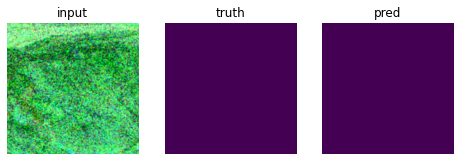

Ep11: tra-> Loss:0.447,Oa:0.864,Miou:0.716, val-> Loss:0.312,Oa:0.927,Miou:0.599,time:7.2s
Ep12: tra-> Loss:0.468,Oa:0.871,Miou:0.678, val-> Loss:0.256,Oa:0.933,Miou:0.670,time:7.3s
Ep13: tra-> Loss:0.430,Oa:0.880,Miou:0.757, val-> Loss:0.219,Oa:0.938,Miou:0.811,time:7.3s
Ep14: tra-> Loss:0.436,Oa:0.875,Miou:0.744, val-> Loss:0.291,Oa:0.937,Miou:0.689,time:7.2s
Ep15: tra-> Loss:0.442,Oa:0.873,Miou:0.733, val-> Loss:0.325,Oa:0.912,Miou:0.624,time:7.2s
Ep16: tra-> Loss:0.415,Oa:0.897,Miou:0.789, val-> Loss:0.243,Oa:0.934,Miou:0.823,time:7.2s
Ep17: tra-> Loss:0.417,Oa:0.899,Miou:0.803, val-> Loss:0.293,Oa:0.928,Miou:0.656,time:7.3s
Ep18: tra-> Loss:0.426,Oa:0.882,Miou:0.762, val-> Loss:0.222,Oa:0.936,Miou:0.824,time:7.3s
Ep19: tra-> Loss:0.421,Oa:0.888,Miou:0.781, val-> Loss:0.283,Oa:0.910,Miou:0.766,time:7.3s
Ep20: tra-> Loss:0.426,Oa:0.881,Miou:0.781, val-> Loss:0.249,Oa:0.938,Miou:0.753,time:7.2s


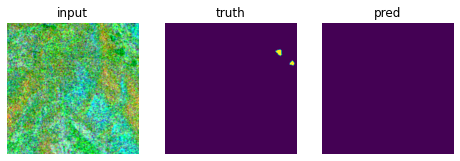

Ep21: tra-> Loss:0.418,Oa:0.880,Miou:0.778, val-> Loss:0.334,Oa:0.908,Miou:0.590,time:7.3s
Ep22: tra-> Loss:0.423,Oa:0.889,Miou:0.770, val-> Loss:0.292,Oa:0.927,Miou:0.668,time:7.7s
Ep23: tra-> Loss:0.434,Oa:0.872,Miou:0.748, val-> Loss:0.221,Oa:0.943,Miou:0.824,time:7.6s
Ep24: tra-> Loss:0.428,Oa:0.876,Miou:0.746, val-> Loss:0.234,Oa:0.913,Miou:0.838,time:7.6s
Ep25: tra-> Loss:0.423,Oa:0.877,Miou:0.766, val-> Loss:0.213,Oa:0.921,Miou:0.824,time:7.7s
Ep26: tra-> Loss:0.423,Oa:0.878,Miou:0.772, val-> Loss:0.280,Oa:0.931,Miou:0.678,time:7.4s
Ep27: tra-> Loss:0.422,Oa:0.896,Miou:0.770, val-> Loss:0.239,Oa:0.937,Miou:0.771,time:7.8s
Ep28: tra-> Loss:0.412,Oa:0.898,Miou:0.810, val-> Loss:0.209,Oa:0.934,Miou:0.846,time:7.5s
Ep29: tra-> Loss:0.407,Oa:0.889,Miou:0.799, val-> Loss:0.225,Oa:0.928,Miou:0.857,time:7.5s
Ep30: tra-> Loss:0.409,Oa:0.888,Miou:0.798, val-> Loss:0.236,Oa:0.941,Miou:0.761,time:7.8s


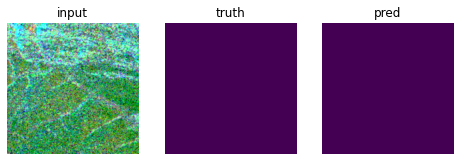

Ep31: tra-> Loss:0.415,Oa:0.899,Miou:0.790, val-> Loss:0.202,Oa:0.935,Miou:0.855,time:7.4s
Ep32: tra-> Loss:0.407,Oa:0.901,Miou:0.811, val-> Loss:0.249,Oa:0.931,Miou:0.736,time:7.7s
Ep33: tra-> Loss:0.401,Oa:0.917,Miou:0.831, val-> Loss:0.241,Oa:0.941,Miou:0.796,time:7.5s
Ep34: tra-> Loss:0.402,Oa:0.908,Miou:0.825, val-> Loss:0.249,Oa:0.942,Miou:0.800,time:7.7s
Ep35: tra-> Loss:0.404,Oa:0.905,Miou:0.819, val-> Loss:0.260,Oa:0.935,Miou:0.780,time:7.7s
Ep36: tra-> Loss:0.407,Oa:0.902,Miou:0.803, val-> Loss:0.216,Oa:0.943,Miou:0.811,time:7.4s
Ep37: tra-> Loss:0.397,Oa:0.918,Miou:0.839, val-> Loss:0.236,Oa:0.947,Miou:0.803,time:7.8s
Ep38: tra-> Loss:0.396,Oa:0.920,Miou:0.843, val-> Loss:0.275,Oa:0.943,Miou:0.743,time:7.4s
Ep39: tra-> Loss:0.387,Oa:0.931,Miou:0.861, val-> Loss:0.241,Oa:0.947,Miou:0.809,time:7.3s
Ep40: tra-> Loss:0.402,Oa:0.896,Miou:0.812, val-> Loss:0.263,Oa:0.945,Miou:0.772,time:7.3s


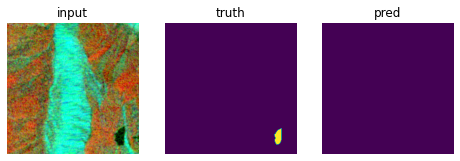

Ep41: tra-> Loss:0.403,Oa:0.915,Miou:0.826, val-> Loss:0.282,Oa:0.912,Miou:0.742,time:7.3s
Ep42: tra-> Loss:0.409,Oa:0.892,Miou:0.801, val-> Loss:0.237,Oa:0.928,Miou:0.787,time:7.3s
Ep43: tra-> Loss:0.408,Oa:0.892,Miou:0.809, val-> Loss:0.205,Oa:0.943,Miou:0.863,time:7.3s
Ep44: tra-> Loss:0.400,Oa:0.919,Miou:0.838, val-> Loss:0.222,Oa:0.953,Miou:0.842,time:7.3s
Ep45: tra-> Loss:0.400,Oa:0.908,Miou:0.832, val-> Loss:0.214,Oa:0.950,Miou:0.846,time:7.4s
Ep46: tra-> Loss:0.398,Oa:0.916,Miou:0.842, val-> Loss:0.209,Oa:0.952,Miou:0.837,time:7.3s
Ep47: tra-> Loss:0.399,Oa:0.920,Miou:0.827, val-> Loss:0.199,Oa:0.921,Miou:0.863,time:7.3s
Ep48: tra-> Loss:0.401,Oa:0.908,Miou:0.822, val-> Loss:0.198,Oa:0.935,Miou:0.897,time:7.3s
Ep49: tra-> Loss:0.404,Oa:0.910,Miou:0.815, val-> Loss:0.207,Oa:0.948,Miou:0.822,time:7.3s
Ep50: tra-> Loss:0.399,Oa:0.920,Miou:0.840, val-> Loss:0.196,Oa:0.941,Miou:0.858,time:7.3s


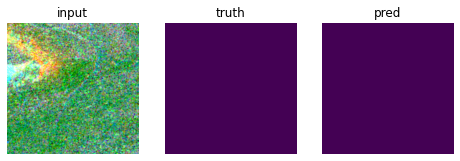

Ep51: tra-> Loss:0.387,Oa:0.925,Miou:0.858, val-> Loss:0.201,Oa:0.905,Miou:0.863,time:7.3s
Ep52: tra-> Loss:0.384,Oa:0.936,Miou:0.866, val-> Loss:0.245,Oa:0.946,Miou:0.780,time:7.3s
Ep53: tra-> Loss:0.377,Oa:0.942,Miou:0.877, val-> Loss:0.226,Oa:0.953,Miou:0.825,time:7.3s
Ep54: tra-> Loss:0.380,Oa:0.934,Miou:0.870, val-> Loss:0.215,Oa:0.953,Miou:0.857,time:7.3s
Ep55: tra-> Loss:0.386,Oa:0.927,Miou:0.857, val-> Loss:0.238,Oa:0.947,Miou:0.803,time:7.3s
Ep56: tra-> Loss:0.384,Oa:0.941,Miou:0.871, val-> Loss:0.194,Oa:0.951,Miou:0.866,time:7.3s
Ep57: tra-> Loss:0.391,Oa:0.927,Miou:0.852, val-> Loss:0.190,Oa:0.952,Miou:0.893,time:7.3s
Ep58: tra-> Loss:0.401,Oa:0.921,Miou:0.823, val-> Loss:0.267,Oa:0.933,Miou:0.759,time:7.3s
Ep59: tra-> Loss:0.391,Oa:0.916,Miou:0.845, val-> Loss:0.175,Oa:0.946,Miou:0.904,time:7.3s
Ep60: tra-> Loss:0.380,Oa:0.938,Miou:0.870, val-> Loss:0.164,Oa:0.955,Miou:0.901,time:7.3s


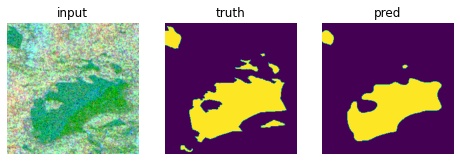

Ep61: tra-> Loss:0.386,Oa:0.933,Miou:0.866, val-> Loss:0.181,Oa:0.955,Miou:0.882,time:7.3s
Ep62: tra-> Loss:0.380,Oa:0.933,Miou:0.868, val-> Loss:0.203,Oa:0.960,Miou:0.845,time:7.3s
Ep63: tra-> Loss:0.374,Oa:0.946,Miou:0.885, val-> Loss:0.172,Oa:0.948,Miou:0.906,time:7.3s
Ep64: tra-> Loss:0.381,Oa:0.932,Miou:0.870, val-> Loss:0.225,Oa:0.863,Miou:0.799,time:7.3s
Ep65: tra-> Loss:0.399,Oa:0.916,Miou:0.822, val-> Loss:0.206,Oa:0.958,Miou:0.849,time:7.3s
Ep66: tra-> Loss:0.390,Oa:0.920,Miou:0.848, val-> Loss:0.179,Oa:0.960,Miou:0.877,time:7.3s
Ep67: tra-> Loss:0.383,Oa:0.937,Miou:0.876, val-> Loss:0.180,Oa:0.960,Miou:0.887,time:7.3s
Ep68: tra-> Loss:0.385,Oa:0.930,Miou:0.860, val-> Loss:0.189,Oa:0.963,Miou:0.890,time:7.3s
Ep69: tra-> Loss:0.390,Oa:0.926,Miou:0.846, val-> Loss:0.192,Oa:0.961,Miou:0.889,time:7.3s
Ep70: tra-> Loss:0.385,Oa:0.929,Miou:0.866, val-> Loss:0.195,Oa:0.958,Miou:0.886,time:7.3s


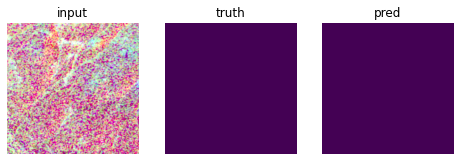

Ep71: tra-> Loss:0.380,Oa:0.937,Miou:0.870, val-> Loss:0.178,Oa:0.970,Miou:0.901,time:7.3s
Ep72: tra-> Loss:0.379,Oa:0.941,Miou:0.881, val-> Loss:0.191,Oa:0.959,Miou:0.893,time:7.3s
Ep73: tra-> Loss:0.384,Oa:0.939,Miou:0.865, val-> Loss:0.268,Oa:0.939,Miou:0.757,time:7.3s
Ep74: tra-> Loss:0.389,Oa:0.933,Miou:0.850, val-> Loss:0.266,Oa:0.911,Miou:0.739,time:7.3s
Ep75: tra-> Loss:0.401,Oa:0.903,Miou:0.817, val-> Loss:0.178,Oa:0.957,Miou:0.894,time:7.3s
Ep76: tra-> Loss:0.384,Oa:0.934,Miou:0.867, val-> Loss:0.201,Oa:0.965,Miou:0.869,time:7.3s
Ep77: tra-> Loss:0.376,Oa:0.945,Miou:0.881, val-> Loss:0.173,Oa:0.962,Miou:0.909,time:7.3s
Ep78: tra-> Loss:0.383,Oa:0.936,Miou:0.866, val-> Loss:0.182,Oa:0.962,Miou:0.899,time:7.3s
Ep79: tra-> Loss:0.379,Oa:0.937,Miou:0.868, val-> Loss:0.185,Oa:0.961,Miou:0.896,time:7.3s
Ep80: tra-> Loss:0.379,Oa:0.945,Miou:0.878, val-> Loss:0.170,Oa:0.959,Miou:0.918,time:7.3s


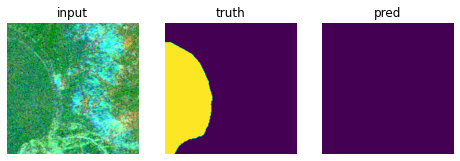

Ep81: tra-> Loss:0.378,Oa:0.936,Miou:0.878, val-> Loss:0.173,Oa:0.965,Miou:0.913,time:7.3s
Ep82: tra-> Loss:0.365,Oa:0.959,Miou:0.904, val-> Loss:0.161,Oa:0.969,Miou:0.910,time:7.3s
Ep83: tra-> Loss:0.370,Oa:0.950,Miou:0.890, val-> Loss:0.163,Oa:0.972,Miou:0.914,time:7.3s
Ep84: tra-> Loss:0.364,Oa:0.953,Miou:0.903, val-> Loss:0.157,Oa:0.965,Miou:0.918,time:7.3s
Ep85: tra-> Loss:0.377,Oa:0.938,Miou:0.873, val-> Loss:0.197,Oa:0.961,Miou:0.883,time:7.3s
Ep86: tra-> Loss:0.373,Oa:0.947,Miou:0.887, val-> Loss:0.159,Oa:0.971,Miou:0.916,time:7.4s
Ep87: tra-> Loss:0.363,Oa:0.960,Miou:0.909, val-> Loss:0.187,Oa:0.959,Miou:0.894,time:7.4s
Ep88: tra-> Loss:0.370,Oa:0.951,Miou:0.893, val-> Loss:0.166,Oa:0.953,Miou:0.910,time:7.3s
Ep89: tra-> Loss:0.394,Oa:0.921,Miou:0.844, val-> Loss:0.290,Oa:0.931,Miou:0.693,time:7.3s
Ep90: tra-> Loss:0.378,Oa:0.938,Miou:0.868, val-> Loss:0.155,Oa:0.968,Miou:0.921,time:7.3s


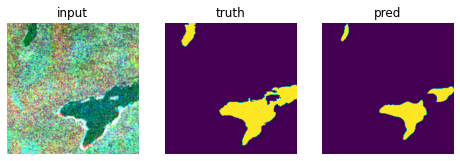

Ep91: tra-> Loss:0.371,Oa:0.949,Miou:0.895, val-> Loss:0.160,Oa:0.973,Miou:0.917,time:7.3s
Ep92: tra-> Loss:0.368,Oa:0.951,Miou:0.894, val-> Loss:0.167,Oa:0.963,Miou:0.911,time:7.3s
Ep93: tra-> Loss:0.369,Oa:0.949,Miou:0.893, val-> Loss:0.191,Oa:0.962,Miou:0.884,time:7.3s
Ep94: tra-> Loss:0.379,Oa:0.943,Miou:0.880, val-> Loss:0.180,Oa:0.967,Miou:0.881,time:7.3s
Ep95: tra-> Loss:0.370,Oa:0.951,Miou:0.894, val-> Loss:0.190,Oa:0.957,Miou:0.879,time:7.3s
Ep96: tra-> Loss:0.366,Oa:0.954,Miou:0.905, val-> Loss:0.172,Oa:0.966,Miou:0.904,time:7.3s
Ep97: tra-> Loss:0.370,Oa:0.943,Miou:0.886, val-> Loss:0.207,Oa:0.957,Miou:0.835,time:7.3s
Ep98: tra-> Loss:0.371,Oa:0.943,Miou:0.887, val-> Loss:0.174,Oa:0.968,Miou:0.902,time:7.3s
Ep99: tra-> Loss:0.365,Oa:0.959,Miou:0.912, val-> Loss:0.157,Oa:0.961,Miou:0.917,time:7.3s
Ep100: tra-> Loss:0.367,Oa:0.954,Miou:0.904, val-> Loss:0.189,Oa:0.963,Miou:0.890,time:7.3s


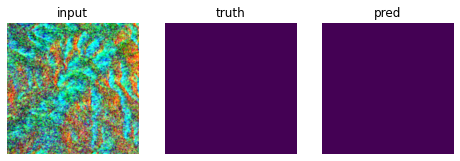

Ep101: tra-> Loss:0.371,Oa:0.944,Miou:0.891, val-> Loss:0.192,Oa:0.961,Miou:0.880,time:7.3s
Ep102: tra-> Loss:0.366,Oa:0.947,Miou:0.893, val-> Loss:0.151,Oa:0.962,Miou:0.924,time:7.3s
Ep103: tra-> Loss:0.375,Oa:0.946,Miou:0.885, val-> Loss:0.176,Oa:0.970,Miou:0.909,time:7.3s
Ep104: tra-> Loss:0.365,Oa:0.952,Miou:0.901, val-> Loss:0.168,Oa:0.969,Miou:0.917,time:7.3s
Ep105: tra-> Loss:0.362,Oa:0.960,Miou:0.910, val-> Loss:0.164,Oa:0.965,Miou:0.916,time:7.3s
Ep106: tra-> Loss:0.368,Oa:0.954,Miou:0.897, val-> Loss:0.175,Oa:0.967,Miou:0.910,time:7.7s
Ep107: tra-> Loss:0.362,Oa:0.958,Miou:0.910, val-> Loss:0.169,Oa:0.973,Miou:0.918,time:7.6s
Ep108: tra-> Loss:0.366,Oa:0.958,Miou:0.909, val-> Loss:0.164,Oa:0.970,Miou:0.915,time:7.5s
Ep109: tra-> Loss:0.368,Oa:0.950,Miou:0.901, val-> Loss:0.181,Oa:0.965,Miou:0.894,time:7.8s
Ep110: tra-> Loss:0.361,Oa:0.959,Miou:0.913, val-> Loss:0.185,Oa:0.968,Miou:0.892,time:7.4s


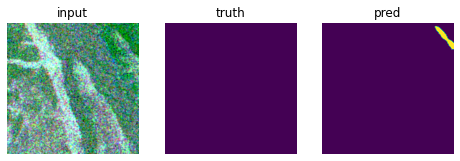

Ep111: tra-> Loss:0.368,Oa:0.949,Miou:0.893, val-> Loss:0.177,Oa:0.966,Miou:0.904,time:7.8s
Ep112: tra-> Loss:0.364,Oa:0.955,Miou:0.908, val-> Loss:0.175,Oa:0.967,Miou:0.897,time:7.5s
Ep113: tra-> Loss:0.365,Oa:0.956,Miou:0.897, val-> Loss:0.169,Oa:0.968,Miou:0.914,time:7.5s
Ep114: tra-> Loss:0.366,Oa:0.953,Miou:0.901, val-> Loss:0.180,Oa:0.960,Miou:0.890,time:7.8s
Ep115: tra-> Loss:0.364,Oa:0.957,Miou:0.907, val-> Loss:0.171,Oa:0.972,Miou:0.911,time:7.4s
Ep116: tra-> Loss:0.370,Oa:0.956,Miou:0.901, val-> Loss:0.184,Oa:0.968,Miou:0.894,time:7.8s
Ep117: tra-> Loss:0.368,Oa:0.954,Miou:0.899, val-> Loss:0.169,Oa:0.969,Miou:0.913,time:7.4s
Ep118: tra-> Loss:0.365,Oa:0.955,Miou:0.905, val-> Loss:0.193,Oa:0.959,Miou:0.883,time:7.8s
Ep119: tra-> Loss:0.360,Oa:0.963,Miou:0.919, val-> Loss:0.196,Oa:0.956,Miou:0.877,time:7.5s
Ep120: tra-> Loss:0.376,Oa:0.940,Miou:0.882, val-> Loss:0.175,Oa:0.971,Miou:0.904,time:7.4s


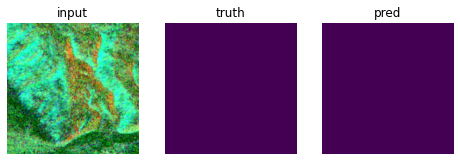

Ep121: tra-> Loss:0.370,Oa:0.945,Miou:0.889, val-> Loss:0.171,Oa:0.970,Miou:0.905,time:7.9s
Ep122: tra-> Loss:0.368,Oa:0.952,Miou:0.899, val-> Loss:0.171,Oa:0.968,Miou:0.909,time:7.5s
Ep123: tra-> Loss:0.362,Oa:0.960,Miou:0.909, val-> Loss:0.173,Oa:0.970,Miou:0.908,time:7.4s
Ep124: tra-> Loss:0.365,Oa:0.955,Miou:0.905, val-> Loss:0.157,Oa:0.969,Miou:0.921,time:7.3s
Ep125: tra-> Loss:0.367,Oa:0.958,Miou:0.907, val-> Loss:0.189,Oa:0.968,Miou:0.880,time:7.3s
Ep126: tra-> Loss:0.365,Oa:0.959,Miou:0.906, val-> Loss:0.165,Oa:0.974,Miou:0.915,time:7.3s
Ep127: tra-> Loss:0.365,Oa:0.956,Miou:0.905, val-> Loss:0.156,Oa:0.971,Miou:0.917,time:7.3s
Ep128: tra-> Loss:0.373,Oa:0.942,Miou:0.886, val-> Loss:0.165,Oa:0.974,Miou:0.907,time:7.3s
Ep129: tra-> Loss:0.364,Oa:0.959,Miou:0.905, val-> Loss:0.163,Oa:0.972,Miou:0.918,time:7.3s
Ep130: tra-> Loss:0.368,Oa:0.948,Miou:0.891, val-> Loss:0.200,Oa:0.956,Miou:0.865,time:7.3s


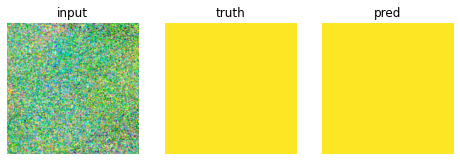

Ep131: tra-> Loss:0.371,Oa:0.946,Miou:0.890, val-> Loss:0.188,Oa:0.959,Miou:0.894,time:7.3s
Ep132: tra-> Loss:0.368,Oa:0.950,Miou:0.896, val-> Loss:0.190,Oa:0.962,Miou:0.882,time:7.3s
Ep133: tra-> Loss:0.360,Oa:0.958,Miou:0.912, val-> Loss:0.181,Oa:0.968,Miou:0.894,time:7.3s
Ep134: tra-> Loss:0.361,Oa:0.955,Miou:0.908, val-> Loss:0.196,Oa:0.960,Miou:0.861,time:7.3s
Ep135: tra-> Loss:0.359,Oa:0.959,Miou:0.911, val-> Loss:0.160,Oa:0.969,Miou:0.917,time:7.3s
Ep136: tra-> Loss:0.367,Oa:0.949,Miou:0.893, val-> Loss:0.170,Oa:0.969,Miou:0.914,time:7.3s
Ep137: tra-> Loss:0.362,Oa:0.957,Miou:0.909, val-> Loss:0.169,Oa:0.973,Miou:0.913,time:7.3s
Ep138: tra-> Loss:0.365,Oa:0.954,Miou:0.901, val-> Loss:0.199,Oa:0.962,Miou:0.867,time:7.3s
Ep139: tra-> Loss:0.364,Oa:0.956,Miou:0.909, val-> Loss:0.184,Oa:0.966,Miou:0.895,time:7.3s
Ep140: tra-> Loss:0.366,Oa:0.953,Miou:0.904, val-> Loss:0.176,Oa:0.968,Miou:0.897,time:7.3s


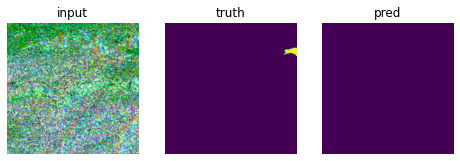

Ep141: tra-> Loss:0.367,Oa:0.955,Miou:0.902, val-> Loss:0.158,Oa:0.961,Miou:0.919,time:7.3s
Ep142: tra-> Loss:0.362,Oa:0.961,Miou:0.910, val-> Loss:0.170,Oa:0.962,Miou:0.909,time:7.3s
Ep143: tra-> Loss:0.363,Oa:0.955,Miou:0.910, val-> Loss:0.164,Oa:0.961,Miou:0.913,time:7.3s
Ep144: tra-> Loss:0.365,Oa:0.960,Miou:0.910, val-> Loss:0.181,Oa:0.968,Miou:0.890,time:7.3s
Ep145: tra-> Loss:0.362,Oa:0.962,Miou:0.917, val-> Loss:0.171,Oa:0.966,Miou:0.911,time:7.3s
Ep146: tra-> Loss:0.359,Oa:0.963,Miou:0.917, val-> Loss:0.173,Oa:0.969,Miou:0.906,time:7.3s
Ep147: tra-> Loss:0.360,Oa:0.963,Miou:0.918, val-> Loss:0.179,Oa:0.970,Miou:0.900,time:7.3s
Ep148: tra-> Loss:0.359,Oa:0.966,Miou:0.924, val-> Loss:0.170,Oa:0.970,Miou:0.910,time:7.3s
Ep149: tra-> Loss:0.369,Oa:0.949,Miou:0.899, val-> Loss:0.157,Oa:0.967,Miou:0.932,time:7.3s
Ep150: tra-> Loss:0.363,Oa:0.960,Miou:0.907, val-> Loss:0.155,Oa:0.965,Miou:0.930,time:7.3s


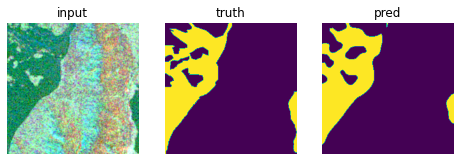

Ep151: tra-> Loss:0.366,Oa:0.955,Miou:0.909, val-> Loss:0.175,Oa:0.967,Miou:0.908,time:7.3s
Ep152: tra-> Loss:0.364,Oa:0.960,Miou:0.912, val-> Loss:0.175,Oa:0.969,Miou:0.908,time:7.3s
Ep153: tra-> Loss:0.360,Oa:0.968,Miou:0.923, val-> Loss:0.168,Oa:0.968,Miou:0.913,time:7.4s
Ep154: tra-> Loss:0.365,Oa:0.957,Miou:0.904, val-> Loss:0.168,Oa:0.966,Miou:0.917,time:7.3s
Ep155: tra-> Loss:0.360,Oa:0.961,Miou:0.913, val-> Loss:0.181,Oa:0.962,Miou:0.899,time:7.3s
Ep156: tra-> Loss:0.367,Oa:0.951,Miou:0.902, val-> Loss:0.176,Oa:0.968,Miou:0.897,time:7.3s
Ep157: tra-> Loss:0.360,Oa:0.963,Miou:0.917, val-> Loss:0.166,Oa:0.972,Miou:0.913,time:7.3s
Ep158: tra-> Loss:0.357,Oa:0.964,Miou:0.922, val-> Loss:0.169,Oa:0.970,Miou:0.912,time:7.3s
Ep159: tra-> Loss:0.362,Oa:0.960,Miou:0.908, val-> Loss:0.158,Oa:0.969,Miou:0.922,time:7.3s
Ep160: tra-> Loss:0.358,Oa:0.960,Miou:0.918, val-> Loss:0.156,Oa:0.971,Miou:0.919,time:7.3s


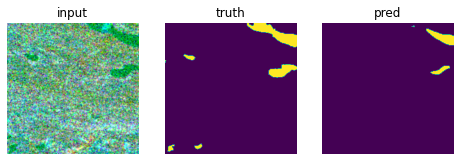

Ep161: tra-> Loss:0.366,Oa:0.956,Miou:0.906, val-> Loss:0.169,Oa:0.970,Miou:0.911,time:7.3s
Ep162: tra-> Loss:0.362,Oa:0.954,Miou:0.910, val-> Loss:0.168,Oa:0.973,Miou:0.911,time:7.3s
Ep163: tra-> Loss:0.367,Oa:0.951,Miou:0.900, val-> Loss:0.183,Oa:0.964,Miou:0.880,time:7.3s
Ep164: tra-> Loss:0.361,Oa:0.961,Miou:0.918, val-> Loss:0.193,Oa:0.960,Miou:0.861,time:7.3s
Ep165: tra-> Loss:0.359,Oa:0.965,Miou:0.918, val-> Loss:0.176,Oa:0.967,Miou:0.900,time:7.3s
Ep166: tra-> Loss:0.360,Oa:0.958,Miou:0.912, val-> Loss:0.165,Oa:0.973,Miou:0.914,time:7.3s
Ep167: tra-> Loss:0.368,Oa:0.959,Miou:0.908, val-> Loss:0.161,Oa:0.972,Miou:0.920,time:7.3s
Ep168: tra-> Loss:0.371,Oa:0.949,Miou:0.899, val-> Loss:0.153,Oa:0.974,Miou:0.932,time:7.3s
Ep169: tra-> Loss:0.371,Oa:0.952,Miou:0.893, val-> Loss:0.166,Oa:0.968,Miou:0.916,time:7.3s
Ep170: tra-> Loss:0.368,Oa:0.947,Miou:0.893, val-> Loss:0.158,Oa:0.975,Miou:0.919,time:7.3s


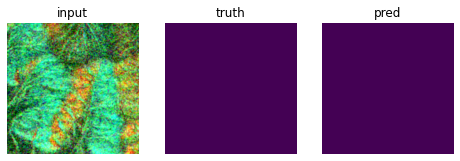

Ep171: tra-> Loss:0.363,Oa:0.957,Miou:0.907, val-> Loss:0.164,Oa:0.971,Miou:0.915,time:7.3s
Ep172: tra-> Loss:0.363,Oa:0.955,Miou:0.905, val-> Loss:0.172,Oa:0.969,Miou:0.906,time:7.3s
Ep173: tra-> Loss:0.361,Oa:0.963,Miou:0.914, val-> Loss:0.172,Oa:0.969,Miou:0.906,time:7.3s
Ep174: tra-> Loss:0.359,Oa:0.966,Miou:0.920, val-> Loss:0.170,Oa:0.970,Miou:0.907,time:7.4s
Ep175: tra-> Loss:0.359,Oa:0.964,Miou:0.916, val-> Loss:0.163,Oa:0.972,Miou:0.916,time:7.3s
Ep176: tra-> Loss:0.365,Oa:0.959,Miou:0.909, val-> Loss:0.169,Oa:0.971,Miou:0.909,time:7.3s
Ep177: tra-> Loss:0.364,Oa:0.959,Miou:0.911, val-> Loss:0.181,Oa:0.967,Miou:0.895,time:7.3s
Ep178: tra-> Loss:0.360,Oa:0.961,Miou:0.917, val-> Loss:0.179,Oa:0.966,Miou:0.896,time:7.3s
Ep179: tra-> Loss:0.358,Oa:0.964,Miou:0.917, val-> Loss:0.170,Oa:0.969,Miou:0.909,time:7.4s
Ep180: tra-> Loss:0.366,Oa:0.954,Miou:0.900, val-> Loss:0.172,Oa:0.970,Miou:0.908,time:7.3s


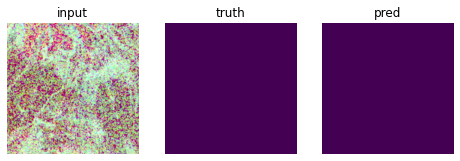

Ep181: tra-> Loss:0.363,Oa:0.958,Miou:0.904, val-> Loss:0.179,Oa:0.967,Miou:0.898,time:7.3s
Ep182: tra-> Loss:0.359,Oa:0.965,Miou:0.919, val-> Loss:0.178,Oa:0.966,Miou:0.899,time:7.3s
Ep183: tra-> Loss:0.360,Oa:0.961,Miou:0.916, val-> Loss:0.176,Oa:0.967,Miou:0.898,time:7.3s
Ep184: tra-> Loss:0.357,Oa:0.965,Miou:0.918, val-> Loss:0.184,Oa:0.966,Miou:0.887,time:7.3s
Ep185: tra-> Loss:0.364,Oa:0.963,Miou:0.915, val-> Loss:0.175,Oa:0.968,Miou:0.904,time:7.3s
Ep186: tra-> Loss:0.357,Oa:0.966,Miou:0.920, val-> Loss:0.172,Oa:0.969,Miou:0.906,time:7.3s
Ep187: tra-> Loss:0.360,Oa:0.964,Miou:0.919, val-> Loss:0.173,Oa:0.969,Miou:0.905,time:7.3s
Ep188: tra-> Loss:0.359,Oa:0.962,Miou:0.918, val-> Loss:0.169,Oa:0.971,Miou:0.911,time:7.3s
Ep189: tra-> Loss:0.358,Oa:0.966,Miou:0.921, val-> Loss:0.168,Oa:0.971,Miou:0.913,time:7.3s
Ep190: tra-> Loss:0.362,Oa:0.962,Miou:0.911, val-> Loss:0.166,Oa:0.971,Miou:0.915,time:7.3s


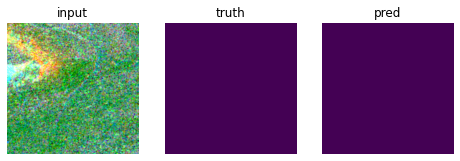

Ep191: tra-> Loss:0.358,Oa:0.965,Miou:0.923, val-> Loss:0.169,Oa:0.971,Miou:0.911,time:7.3s
Ep192: tra-> Loss:0.358,Oa:0.966,Miou:0.922, val-> Loss:0.169,Oa:0.971,Miou:0.911,time:7.3s
Ep193: tra-> Loss:0.358,Oa:0.964,Miou:0.925, val-> Loss:0.166,Oa:0.971,Miou:0.913,time:7.3s
Ep194: tra-> Loss:0.356,Oa:0.964,Miou:0.922, val-> Loss:0.163,Oa:0.971,Miou:0.916,time:7.3s
Ep195: tra-> Loss:0.359,Oa:0.961,Miou:0.914, val-> Loss:0.166,Oa:0.970,Miou:0.914,time:7.3s
Ep196: tra-> Loss:0.362,Oa:0.962,Miou:0.910, val-> Loss:0.163,Oa:0.970,Miou:0.917,time:7.3s
Ep197: tra-> Loss:0.362,Oa:0.959,Miou:0.913, val-> Loss:0.165,Oa:0.970,Miou:0.915,time:7.3s
Ep198: tra-> Loss:0.366,Oa:0.951,Miou:0.903, val-> Loss:0.166,Oa:0.972,Miou:0.913,time:7.3s
Ep199: tra-> Loss:0.362,Oa:0.960,Miou:0.912, val-> Loss:0.168,Oa:0.972,Miou:0.913,time:7.3s
Ep200: tra-> Loss:0.361,Oa:0.958,Miou:0.916, val-> Loss:0.168,Oa:0.971,Miou:0.914,time:7.3s


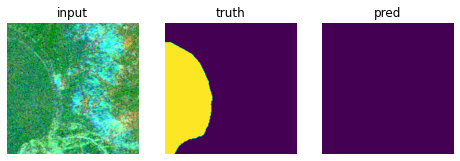

In [ ]:
metrics = train_loops(model=model,  
                    loss_fn=config.loss_bce,  
                    optimizer=optimizer,  
                    tra_loader=tra_loader,  
                    val_loader=val_loader,  
                    epoches=config.epoch,   
                    lr_scheduler=lr_scheduler)


## Model and metrics saving


In [ ]:
# model_name = 'model_single_test_11'
# # model save/load
# model_weights = config.root_proj + '/model/pretrained/model_single_test/' + model_name + '_weights.pth'
# torch.save(model.state_dict(), model_weights)
# # model.load_state_dict(torch.load(model_weights))


In [ ]:
# ## metrics saving
# metrics_path = config.root_proj + '/model/pretrained/model_single_test/' + model_name + '_metrics.csv'
# metrics_df = pd.DataFrame(metrics)
# metrics_df.to_csv(metrics_path, index=False, sep=',')
# # metrics_df = pd.read_csv(metrics_path)
